In [27]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [28]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# Classification number setting

In [29]:
NUM_CLASSES = 5

# input length

In [30]:
TIME_STEPS = 16
DIMENSION = 2

# Load learning data

In [31]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [32]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [34]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [35]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 24)                792       
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                250       
                                                                 
 dense_8 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Model Checkpoint Callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path.replace('.hdf5', '.keras'), verbose=1, save_weights_only=False)
# Early Abort Callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [37]:
# model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model training

In [38]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
16/32 [==============>...............] - ETA: 0s - loss: 1.6144 - accuracy: 0.1313 
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.keras
32/32 [==============================] - 1s 10ms/step - loss: 1.6052 - accuracy: 0.1970 - val_loss: 1.5853 - val_accuracy: 0.2535
Epoch 2/1000
22/32 [===================>..........] - ETA: 0s - loss: 1.5772 - accuracy: 0.3097
Epoch 2: saving model to model/point_history_classifier\point_history_classifier.keras
32/32 [==============================] - 0s 5ms/step - loss: 1.5738 - accuracy: 0.3014 - val_loss: 1.5551 - val_accuracy: 0.2403
Epoch 3/1000
23/32 [====================>.........] - ETA: 0s - loss: 1.5477 - accuracy: 0.3567
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.keras
32/32 [==============================] - 0s 5ms/step - loss: 1.5418 - accuracy: 0.3801 - val_loss: 1.5213 - val_accuracy: 0.4739
Epoch 4/1000
23/32 [====================>.........] - ETA: 0s 

In [39]:
# Loading a saved model
model = tf.keras.models.load_model(model_save_path)

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 32], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [ ]:
# Reasoning test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[0.9438374  0.01624594 0.01188834 0.02802826]
0


# Mixed rows

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


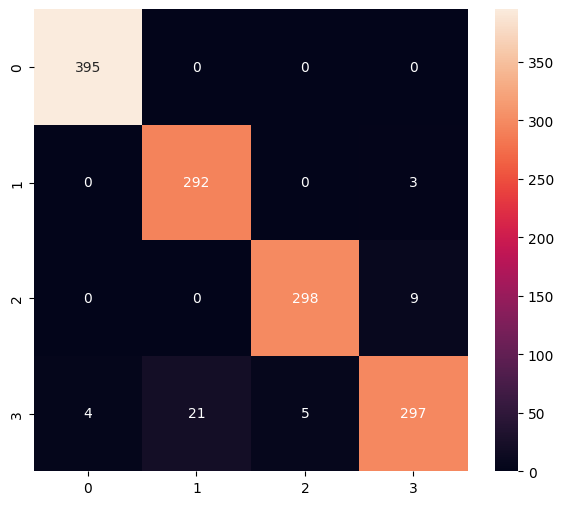

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.93      0.99      0.96       295
           2       0.98      0.97      0.98       307
           3       0.96      0.91      0.93       327

    accuracy                           0.97      1324
   macro avg       0.97      0.97      0.97      1324
weighted avg       0.97      0.97      0.97      1324



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite Convert to Lite model

In [ ]:
# Save as an inference-only model
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [ ]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [ ]:
# Transform the model (quantize
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Abhis\AppData\Local\Temp\tmp4n3jicfy\assets


INFO:tensorflow:Assets written to: C:\Users\Abhis\AppData\Local\Temp\tmp4n3jicfy\assets


Saved artifact at 'C:\Users\Abhis\AppData\Local\Temp\tmp4n3jicfy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1306977054032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1306977057296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1306977053648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1306977057872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1306977056720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1306977055952: TensorSpec(shape=(), dtype=tf.resource, name=None)


6452

# Reasoning test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\python files\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
# Get input/output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.9438374  0.01624594 0.01188834 0.02802827]
0
